# Aufgabe 1
Implementieren Sie die Algorithmen aus Aufgabe 1 in Python. Ihnen steht folgendes Interface zur Verfügung:
Gegeben ist eine Basisklasse namens `Scheduler`. Diese kann genutzt werden, um eine Liste von Task-Objekten dynamisch zu planen.
Dafür muss der Methode `Scheduler.schedule` eine Liste solcher Task-Objekte übergeben werden.

Das eigentliche Verhalten von `Scheduler` kann mithilfe der Methode `Scheduler.update` implementiert werden.
Indem Sie von `Scheduler` erben, können Sie diese Methode überschreiben und um ihren eigenen Code ergänzen.
Auf diese Weise haben sie Zugriff auf interne Variablen von `Scheduler`.
Für Sie interessant sind vor allem:
+ `self.current_task`: der aktuelle Task (wurde im vorherigen Zeitpunkt bearbeitet, `None` im Idle-Fall). Muss immer in `self.tasks_active` enthalten sein.
+ `self.tasks_active`: Liste mit allen Tasks, die ausführbereit sind. Diese Liste wird automatisch mit der verbleibenden Zeit aller Tasks aktualisiert. Das `duration` Feld eines Tasks entspricht hier also der verbleibenden Zeit.
Wenn in einem Zeitpunkt die Ankunftszeit von Tasks erreicht wurde, dann werden diese "neuen" Tasks im Parameter `new_tasks` übergeben.

Um die Funktionsweise zu verdeutlichen, ist im Folgenden ein Algorithmus implementiert, der einen zufälligen Task zur Ausführung auswählt, sobald der vorherige abgeschlossen wurde.

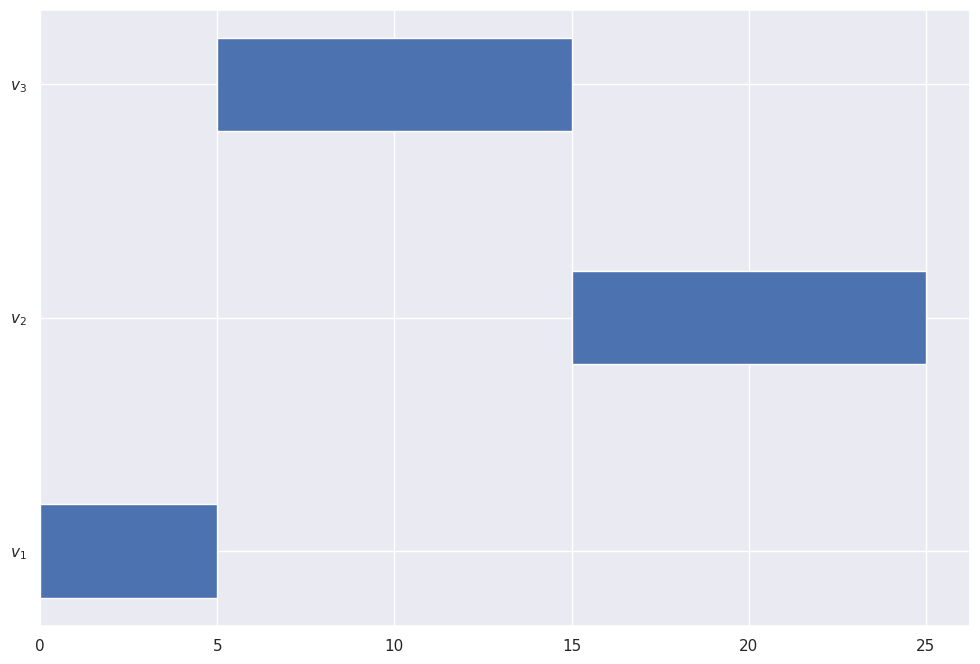

In [1]:
from scheduler.scheduler import *
import random


class Random(Scheduler):
    def update(self, new_tasks):
        if len(new_tasks) != 0:
            self.tasks_active += new_tasks

        if len(self.tasks_active) > 0 and self.current_task == None:
            # pick a number from 0 to #of available tasks
            task_id = random.randrange(len(self.tasks_active))
            self.current_task = self.tasks_active[task_id]


# Plane ein paar Beispielstasks
task_list = [
    Task(id=1, duration=5, release=0),
    Task(id=2, duration=10, release=0),
    Task(id=3, duration=10, release=0),
]

scheduler = Random()
random_schedule = scheduler.schedule(task_list)
gantt_chart(random_schedule)

Nutzen Sie nun das vorherige Beispiel, um die anderen Algorithmen zu implementieren.
In der folgenden Codezelle ist die Liste an Tasks aus Aufgabe 1 definiert, sodass sie ihre Ergebnisse vergleichen können.

In [2]:
task_list = [
    Task(id=1, duration=20, release=0, priority=2),
    Task(id=2, duration=5, release=0, priority=1),
    Task(id=3, duration=10, release=5, priority=4),
    Task(id=4, duration=5, release=20, priority=3),
    Task(id=5, duration=20, release=50, priority=6),
    Task(id=6, duration=5, release=50, priority=7),
]

## First Come First Served

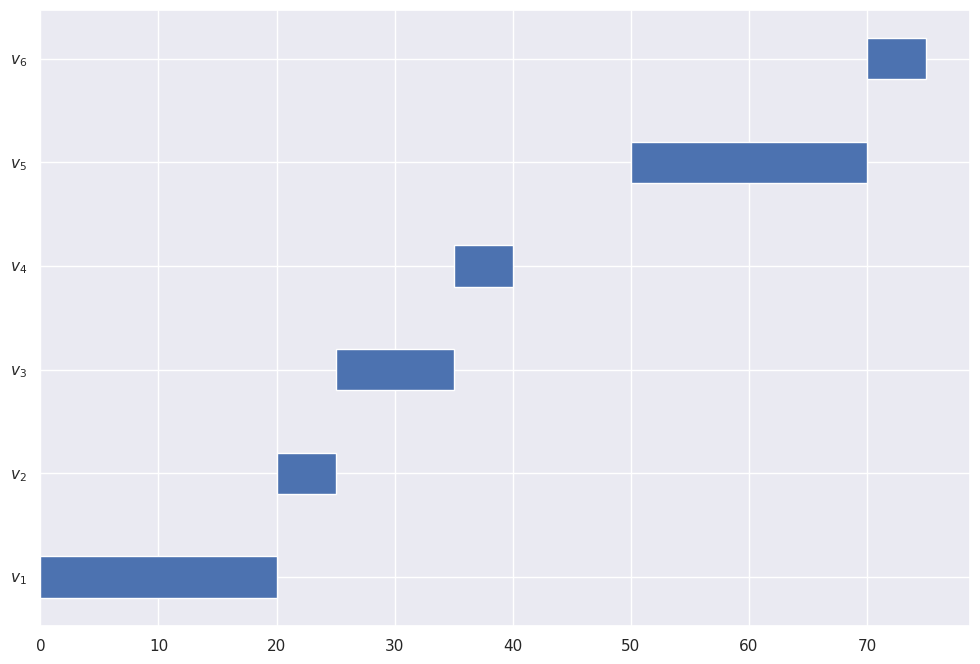

In [3]:
class FCFS(Scheduler):
    def update(self, new_tasks):
        # new tasks arrived
        if len(new_tasks) != 0:
            self.tasks_active += new_tasks

        if self.current_task is None and len(self.tasks_active) > 0:
            self.current_task = self.tasks_active[0]


scheduler = FCFS()
fcfs_schedule = scheduler.schedule(task_list)
gantt_chart(fcfs_schedule)

## Shortest Job First

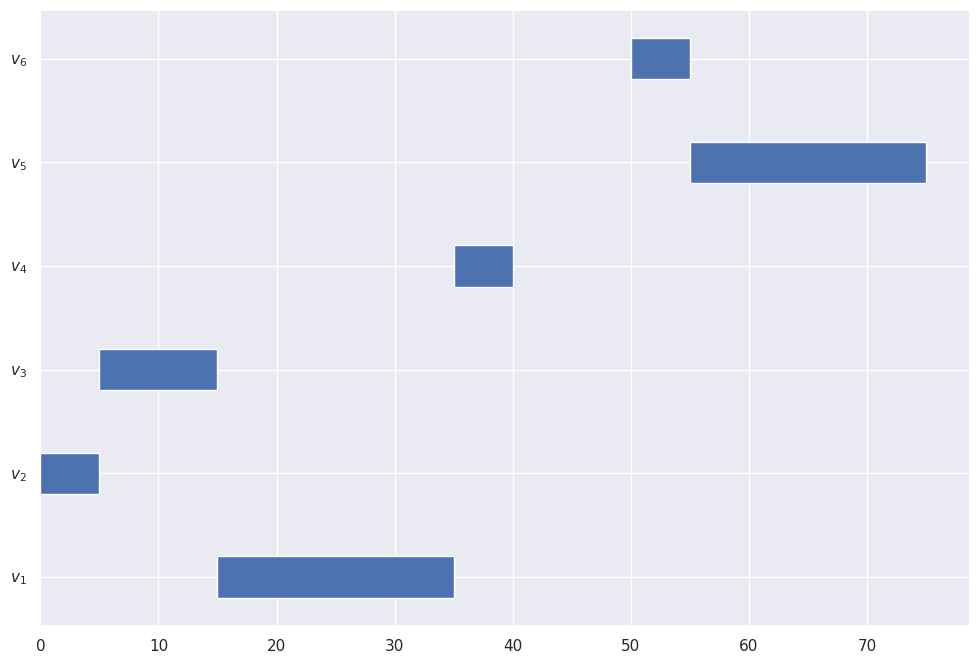

In [4]:
class SJF(Scheduler):
    def update(self, new_tasks):
        # some tasks are new, just append them
        if len(new_tasks) != 0:
            self.tasks_active += new_tasks
            self.tasks_active.sort(key=lambda task: task.duration)

        if self.current_task is None and len(self.tasks_active) > 0:
            self.current_task = self.tasks_active[0]


scheduler = SJF()
sjf_schedule = scheduler.schedule(task_list)
gantt_chart(sjf_schedule)

## Shortest Remaining Time Next

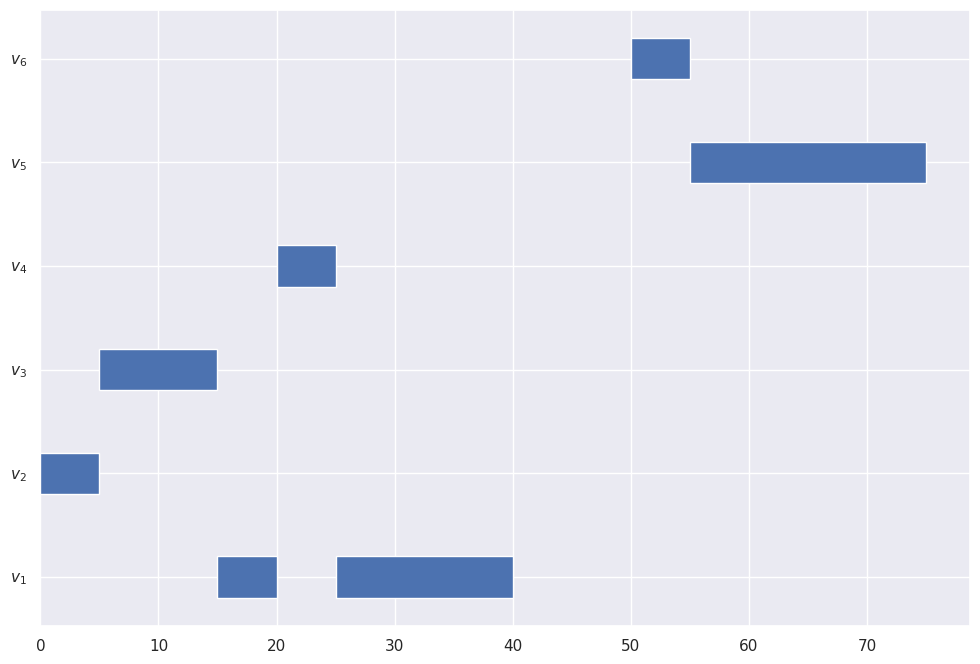

In [5]:
class SRTN(Scheduler):
    def update(self, new_tasks) -> Task:
        # some tasks are new, just append them
        if len(new_tasks) != 0:
            self.tasks_active += new_tasks
            self.tasks_active.sort(key=lambda task: task.duration)

        if len(self.tasks_active) > 0:
            self.current_task = self.tasks_active[0]


scheduler = SRTN()
srtn_schedule = scheduler.schedule(task_list)
gantt_chart(srtn_schedule)

## Prioritätsscheduling

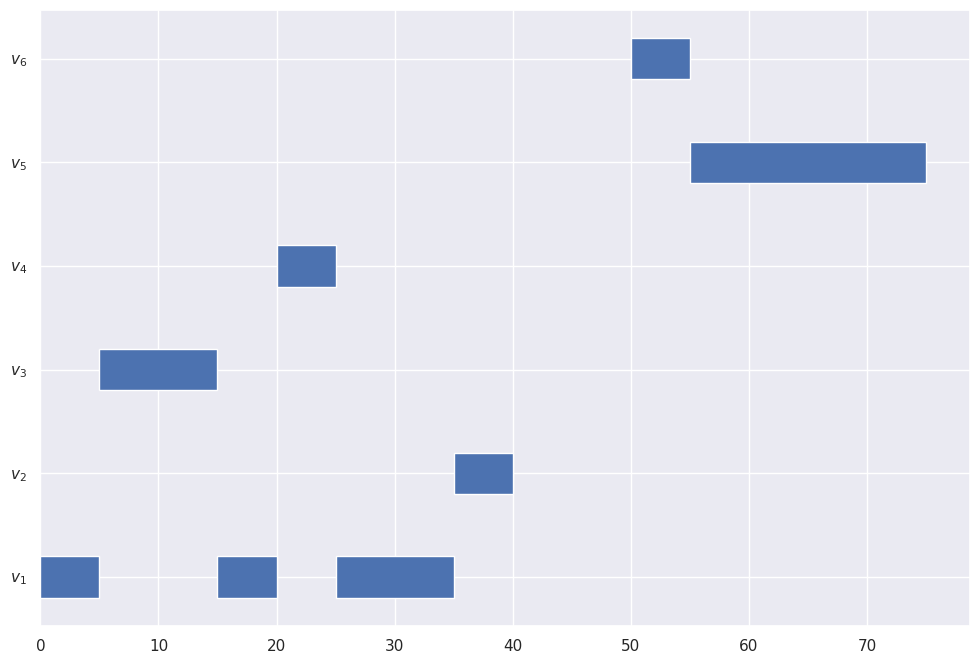

In [6]:
class Priority(Scheduler):
    def update(self, new_tasks):
        if len(new_tasks) != 0:
            self.tasks_active += new_tasks
            self.tasks_active.sort(key=lambda task: -task.priority)

        if len(self.tasks_active) > 0:
            self.current_task = self.tasks_active[0]


scheduler = Priority()
prio_schedule = scheduler.schedule(task_list)
gantt_chart(prio_schedule)

# Aufgabe 2

Berechnen sie mithilfe des `schedule` Objekts die Latenz und die CPU-Auslastung der berechneten Ablaufpläne.

In [7]:
def response_time_for_task(schedule, task):
    slices = schedule[task.id]

    # slices[-1][1] gets the end of the last slice
    return slices[-1][1] - task.release


def waiting_time_for_task(schedule, task):
    slices = schedule[task.id]
    return slices[-1][1] - task.release - task.duration


def cpu_utilization(schedule):
    all_slices = list()
    for task in schedule.values():
        # if the task was suspended, it was processed in more than one slice
        if isinstance(task, list):
            for slice in task:
                all_slices.append(slice)
        else:
            all_slices.append(task)

    all_slices.sort(key=lambda time: time[0])  # sort by start time

    # add up all time that was skipped
    sum_skipped = 0
    for i, _ in enumerate(all_slices[1:]):
        start = all_slices[i][0]
        prev_end = all_slices[i - 1][1]
        if start > prev_end:
            sum_skipped += start - prev_end

    total_time = all_slices[-1][1] - all_slices[0][0]
    return 1 - (sum_skipped / total_time)


print(f"{cpu_utilization(fcfs_schedule)}")
print(f"{cpu_utilization(sjf_schedule)}")
print(f"{cpu_utilization(srtn_schedule)}")
print(f"{cpu_utilization(prio_schedule)}")


for schedule in [fcfs_schedule, sjf_schedule, srtn_schedule, prio_schedule]:
    print("-----------------------------------")
    print("Response Time:")
    sum_response_time = 0
    # reversal is just so it is printed like in the solution
    for task in reversed(task_list):
        response_time = response_time_for_task(schedule, task)
        sum_response_time += response_time
        print(f"{task.id}: {response_time}")
    avg_response_time = sum_response_time / 6
    print(f"average: {avg_response_time}")
    print("\n")

    print("Flow Time:")
    sum_flow_time = 0
    # reversal is just so it is printed like in the solution
    for task in reversed(task_list):
        flow_time = waiting_time_for_task(schedule, task)
        sum_flow_time += flow_time
        print(f"{task.id}: {flow_time}")
    avg_flow_time = sum_flow_time / 6
    print(f"average: {avg_flow_time}")

0.8666666666666667
0.8666666666666667
0.8666666666666667
0.8666666666666667
-----------------------------------
Response Time:
6: 25
5: 20
4: 20
3: 30
2: 25
1: 20
average: 23.333333333333332


Flow Time:
6: 20
5: 0
4: 15
3: 20
2: 20
1: 0
average: 12.5
-----------------------------------
Response Time:
6: 5
5: 25
4: 20
3: 10
2: 5
1: 35
average: 16.666666666666668


Flow Time:
6: 0
5: 5
4: 15
3: 0
2: 0
1: 15
average: 5.833333333333333
-----------------------------------
Response Time:
6: 5
5: 25
4: 5
3: 10
2: 5
1: 40
average: 15.0


Flow Time:
6: 0
5: 5
4: 0
3: 0
2: 0
1: 20
average: 4.166666666666667
-----------------------------------
Response Time:
6: 5
5: 25
4: 5
3: 10
2: 40
1: 35
average: 20.0


Flow Time:
6: 0
5: 5
4: 0
3: 0
2: 35
1: 15
average: 9.166666666666666
